In [18]:
# import mne

from pathlib import Path

import mne
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.dataset_utils import build_manifest_simple, save_manifest

## 0. Create manifest

In [66]:
DATASET_PATH = Path("C:/Users/MDBI/Documents/public-datasets/sleepy-rat/")

df = build_manifest_simple(DATASET_PATH)
save_manifest(df, DATASET_PATH / "manifest.csv")

In [67]:
df

,cohort,animal_id,edf_path,scoring_path,has_scoring
0,CohortA,A1,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True
1,CohortA,A2,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True
2,CohortA,A3,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True
3,CohortA,A4,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True
4,CohortB,B1,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True
5,CohortB,B2,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True
6,CohortB,B3,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True
7,CohortB,B4,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True
8,CohortC,C1,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True
9,CohortC,C2,C:\Users\MDBI\Documents\public-datasets\sleepy...,C:\Users\MDBI\Documents\public-datasets\sleepy...,True


## 1. Load single EEG-recording

In [79]:
manifest = pd.read_csv("C:/Users/MDBI/Documents/public-datasets/sleepy-rat/manifest.csv")      # or use your in-memory df

row = manifest.iloc[0]
raw = mne.io.read_raw_edf(str(row['edf_path']), preload=True, stim_channel=None, verbose=False)
raw

<RawEDF | A1.edf, 3 x 11059200 (86400.0 s), ~253.1 MB, data loaded>

In [80]:
print(raw)                # basic info
print(raw.info["sfreq"])  # sampling rate (Hz)
print(raw.info["ch_names"])

<RawEDF | A1.edf, 3 x 11059200 (86400.0 s), ~253.1 MB, data loaded>
128.0
['EEG1', 'EEG2', 'EMG']


### Tell MNE what type of data is in each channel, is it EEG or EMG?

In [81]:
# Example mapping — adjust to your channel names:
mapping = {
    "EEG1": "eeg",     # or "EEG1"
    "EEG2": "eeg",
    "EMG": "emg"
}
present = {ch: tp for ch, tp in mapping.items() if ch in raw.ch_names}
if present:
    raw.set_channel_types(present)

raw

<RawEDF | A1.edf, 3 x 11059200 (86400.0 s), ~253.1 MB, data loaded>

### Load scorings

In [82]:
scorings = pd.read_csv(row['scoring_path'], index_col=0, names = ["score_1", "score_2"])

In [83]:
scorings

,score_1,score_2
0,n,n
1,n,n
2,n,n
3,n,n
4,n,n
...,...,...
10795,w,w
10796,w,w
10797,w,w
10798,w,w


In [501]:
scorings[scorings.score_1 != scorings.score_2]

,score_1,score_2
16,2,n
24,n,2
34,2,n
35,2,n
47,2,n
...,...,...
10618,w,n
10619,w,n
10620,w,n
10621,w,n


## 2. Pre-processing steps for one EEG-recording

In [84]:
from pathlib import Path
import numpy as np
import pandas as pd
import mne

# ---------- load from your manifest ----------
row = manifest.iloc[0]                                
EDF_PATH = Path(row["edf_path"])
SCORING_CSV = Path(row["scoring_path"]) if pd.notna(row["scoring_path"]) else None


# ---------- parameters you can tweak ----------
EPOCH_LEN = 4.0         # mouse sleep scoring commonly 10 or 20 s; you have 20 s in many datasets
LINE_FREQ = 50.0         # set 60.0 if you're in a 60 Hz mains region
HP = 0.5                 # high-pass (Hz)
LP = 45.0                # low-pass (Hz); below hardware 64 Hz is fine
TARGET_SFREQ = 128.0     # you are already at 128 Hz; keep it consistent


# ---- 1) Load EDF header (lazy) ----
raw = mne.io.read_raw_edf(str(EDF_PATH), preload=False, stim_channel=None, verbose=False)

# Mark channel types (adjust names if yours differ)
eeg_like = [ch for ch in raw.ch_names if "EEG" in ch.upper()]
emg_like = [ch for ch in raw.ch_names if "EMG" in ch.upper()]
if eeg_like: raw.set_channel_types({ch: "eeg" for ch in eeg_like})
if emg_like: raw.set_channel_types({ch: "emg" for ch in emg_like})

# ---- 2) Read your scoring file (3 columns, no header) ----
# Accept comma OR semicolon just in case; strip spaces
sc = pd.read_csv(SCORING_CSV, header=None, names=["epoch", "score_1", "score_2"],
                 sep=r"[;,]", engine="python")
sc["score_1"] = sc["score_1"].astype(str).str.strip()
sc["score_2"] = sc["score_2"].astype(str).str.strip()

# Map label codes to canonical names
LABEL_MAP = {
    "w":"Wake", "wake":"Wake", "W":"Wake",
    "n":"NREM", "nr":"NREM", "N":"NREM", "NREM":"NREM",
    "r":"REM",  "rem":"REM", "R":"REM"
}

def norm_label(x: str) -> str:
    s = str(x).strip()
    return LABEL_MAP.get(s, LABEL_MAP.get(s.lower(), "Unknown"))

# Simple consensus between the two raters
PRIORITY = {"REM": 3, "NREM": 2, "Wake": 1, "Unknown": 0}
def consensus(a, b) -> str:
    a, b = norm_label(a), norm_label(b)
    if a == b: return a
    # tie-breaker: REM > NREM > Wake
    return a if PRIORITY[a] >= PRIORITY[b] else b

sc["stage"] = [consensus(a, b) for a, b in zip(sc["score_1"], sc["score_2"])]

# ---- 3) Turn rows into onsets/durations ----
rec_dur = float(raw.times[-1])                 # seconds
n_rows  = len(sc)
epoch_len = rec_dur / n_rows                   # ~4.0 s for your file
onsets   = np.arange(n_rows, dtype=float) * epoch_len
durations= np.full(n_rows, epoch_len, dtype=float)

# ---- 4) Attach annotations, crop to scored span, then load data ----
ann = mne.Annotations(onset=onsets, duration=durations,
                      description=sc["stage"].astype(str).to_numpy())
raw.set_annotations(ann)

raw.crop(tmin=float(onsets.min()), tmax=float(onsets.max() + epoch_len))
raw.load_data()

# ---- 5) Denoise (line + bands) ----
LINE = 50.0   # set to 60.0 if you're in a 60 Hz mains region
raw.notch_filter([LINE])

picks_eeg = mne.pick_types(raw.info, eeg=True,  emg=False)
picks_emg = mne.pick_types(raw.info, eeg=False, emg=True)

if len(picks_eeg):
    raw.filter(0.5, 45.0, picks=picks_eeg)   # EEG: sleep band
if len(picks_emg):
    raw.filter(10.0, 45.0, picks=picks_emg)  # EMG: keep activity band

# Optional average ref if ≥2 EEG
if len(picks_eeg) >= 2:
    raw.set_eeg_reference("average")

# ---- 6) Make per-epoch data (4 s) ----
event_id = {"Wake": 1, "NREM": 2, "REM": 3}
events = []
for onset, label in zip(onsets, sc["stage"]):
    if label not in event_id:    # skip Unknown
        continue
    events.append([int(round(onset * raw.info["sfreq"])), 0, event_id[label]])
events = np.asarray(events, dtype=int)

epochs4 = mne.Epochs(raw, events=events, event_id=event_id,
                     tmin=0.0, tmax=epoch_len, baseline=None,
                     preload=True, reject_by_annotation=True)

print(f"Epochs shape: {epochs4.get_data().shape}  (n_epochs, n_channels, n_times)")
# Optional: rebin to 20 s (group 5×4 s)
# ...

# ---- 7) Save outputs ----
raw.save("C:/Users/MDBI/Documents/public-datasets/sleepy-rat/processed-data/raw_preproc.fif", overwrite=True)
epochs4.save("C:/Users/MDBI/Documents/public-datasets/sleepy-rat/processed-data/epochs4s-epo.fif", overwrite=True)


Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.5

C:\Users\MDBI\AppData\Local\Temp\ipykernel_27960\1852924688.py:106: RuntimeWarning: This filename (C:\Users\MDBI\Documents\public-datasets\sleepy-rat\processed-data\raw_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save("C:/Users/MDBI/Documents/public-datasets/sleepy-rat/processed-data/raw_preproc.fif", overwrite=True)


Closing C:\Users\MDBI\Documents\public-datasets\sleepy-rat\processed-data\raw_preproc.fif
[done]
Overwriting existing file.
Overwriting existing file.


In [85]:
raw

<RawEDF | A1.edf, 3 x 11059200 (86400.0 s), ~253.1 MB, data loaded>

In [75]:
epochs4

<Epochs | 21597 events (all good), 0 – 4 s (baseline off), ~253.6 MB, data loaded,
 'Wake': 10564
 'NREM': 8539
 'REM': 2494>

In [76]:
import numpy as np
import pandas as pd
import mne

# Frequency bands (tweak if you like)
BANDS = {
    "delta": (0.5, 4.0),
    "theta": (6.0, 9.0),
    "sigma": (10.0, 15.0),
    "beta":  (15.0, 30.0),
}

def _integrate_band(psd, freqs, fmin, fmax):
    """Integrate power between fmin..fmax using the trapezoid rule."""
    idx = (freqs >= fmin) & (freqs < fmax)
    if not np.any(idx):
        return np.zeros(psd.shape[:-1])
    return np.trapz(psd[..., idx], freqs[idx], axis=-1)

def extract_epoch_features(epochs: mne.Epochs,
                           eeg_picks=None,
                           emg_pick=None,
                           bands=BANDS) -> tuple[pd.DataFrame, np.ndarray]:
    """
    Returns:
      - X: DataFrame (one row per epoch)
      - y: array of stage labels ('Wake','NREM','REM') from epochs.event_id
    """
    sfreq = epochs.info["sfreq"]

    # --- labels y from events ---
    inv_id = {v: k for k, v in epochs.event_id.items()}
    y = np.array([inv_id.get(code, "Unknown") for code in epochs.events[:, 2]])

    # --- choose channels ---
    if eeg_picks is None:
        eeg_picks = mne.pick_types(epochs.info, eeg=True, emg=False)
    if emg_pick is None:
        emg_candidates = mne.pick_types(epochs.info, eeg=False, emg=True)
        emg_pick = emg_candidates[0] if len(emg_candidates) else None

    # --- EEG PSD (Welch) ---
    # Using MNE's built-in welch on epochs; returns V^2/Hz
    psd = epochs.compute_psd(method="welch", fmin=0.5, fmax=45.0)
    freqs = psd.freqs
    psd_eeg = psd.get_data(picks=eeg_picks)  # (n_epochs, n_eeg, n_freqs)
    if psd_eeg.size == 0:
        raise RuntimeError("No EEG channels found. Check channel types.")
    psd_eeg_mean = psd_eeg.mean(axis=1)      # average across EEG channels → (n_epochs, n_freqs)

    # Total power in analysis band
    total = _integrate_band(psd_eeg_mean, freqs, 0.5, 45.0) + 1e-20  # +eps to avoid div/0

    # Bandpowers (absolute and relative)
    feats = {}
    for name, (f1, f2) in bands.items():
        bp = _integrate_band(psd_eeg_mean, freqs, f1, f2)           # V^2
        feats[f"{name}_abs"] = bp
        feats[f"{name}_rel"] = bp / total

    # Simple EEG ratios
    feats["theta_delta"] = feats["theta_abs"] / (feats["delta_abs"] + 1e-20)
    feats["sigma_delta"] = feats["sigma_abs"] / (feats["delta_abs"] + 1e-20)

    # --- EMG features (RMS) ---
    if emg_pick is not None:
        emg = epochs.get_data(picks=[emg_pick])[:, 0, :]  # (n_epochs, n_times)
        emg_rms_v = np.sqrt((emg ** 2).mean(axis=1))      # in Volts
        feats["emg_rms_uv"] = emg_rms_v * 1e6             # report in µV
        feats["emg_rms_log"] = np.log10(feats["emg_rms_uv"] + 1e-6)
    else:
        feats["emg_rms_uv"] = np.zeros(len(y))
        feats["emg_rms_log"] = np.zeros(len(y))

    # Assemble DataFrame
    X = pd.DataFrame(feats)
    return X, y


In [77]:
X_one, y_one = extract_epoch_features(epochs4)
X_one.head(), np.unique(y_one, return_counts=True)

Effective window size : 4.008 (s)


C:\Users\MDBI\AppData\Local\Temp\ipykernel_27960\1735457699.py:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[..., idx], freqs[idx], axis=-1)


(      delta_abs  delta_rel     theta_abs  theta_rel     sigma_abs  sigma_rel  \
 0  1.424768e-10   0.114969  2.160520e-10   0.174340  3.300775e-10   0.266351   
 1  2.720282e-10   0.180978  1.633843e-10   0.108698  3.307798e-10   0.220065   
 2  3.060551e-10   0.212357  2.520312e-10   0.174872  2.243878e-10   0.155692   
 3  3.448240e-10   0.139380  5.506970e-10   0.222595  5.821324e-10   0.235302   
 4  3.805450e-10   0.151019  5.054402e-10   0.200583  6.454865e-10   0.256161   
 
        beta_abs  beta_rel  theta_delta  sigma_delta  emg_rms_uv  emg_rms_log  
 0  2.114217e-10  0.170603     1.516402     2.316711   27.976080     1.446787  
 1  3.267474e-10  0.217383     0.600615     1.215976   22.469516     1.351594  
 2  2.326511e-10  0.161425     0.823483     0.733161   21.324376     1.328876  
 3  4.648554e-10  0.187898     1.597038     1.688202   24.588754     1.390737  
 4  2.697594e-10  0.107054     1.328201     1.696216   27.791812     1.443917  ,
 (array(['NREM', 'REM', 'Wake']

In [78]:
X_one

,delta_abs,delta_rel,theta_abs,theta_rel,sigma_abs,sigma_rel,beta_abs,beta_rel,theta_delta,sigma_delta,emg_rms_uv,emg_rms_log
0,1.424768e-10,0.114969,2.160520e-10,0.174340,3.300775e-10,0.266351,2.114217e-10,0.170603,1.516402,2.316711,27.976080,1.446787
1,2.720282e-10,0.180978,1.633843e-10,0.108698,3.307798e-10,0.220065,3.267474e-10,0.217383,0.600615,1.215976,22.469516,1.351594
2,3.060551e-10,0.212357,2.520312e-10,0.174872,2.243878e-10,0.155692,2.326511e-10,0.161425,0.823483,0.733161,21.324376,1.328876
3,3.448240e-10,0.139380,5.506970e-10,0.222595,5.821324e-10,0.235302,4.648554e-10,0.187898,1.597038,1.688202,24.588754,1.390737
4,3.805450e-10,0.151019,5.054402e-10,0.200583,6.454865e-10,0.256161,2.697594e-10,0.107054,1.328201,1.696216,27.791812,1.443917
...,...,...,...,...,...,...,...,...,...,...,...,...
21592,8.152086e-11,0.062781,4.328103e-10,0.333317,2.703968e-10,0.208239,2.150307e-10,0.165600,5.309197,3.316903,35.963510,1.555862
21593,1.207700e-10,0.113713,3.468966e-10,0.326628,2.133983e-10,0.200930,1.665801e-10,0.156847,2.872374,1.766981,44.334133,1.646738
21594,4.051657e-11,0.033221,1.032704e-10,0.084674,2.960185e-10,0.242713,2.103430e-10,0.172466,2.548844,7.306108,31.980311,1.504883
21595,2.919143e-10,0.175854,2.069523e-10,0.124672,3.903967e-10,0.235182,3.329385e-10,0.200568,0.708949,1.337368,34.064550,1.532303


## 3. Pre-process all data

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import mne

# Stage / artifact handling
STAGE_MAP = {"w":"Wake", "n":"NREM", "r":"REM", "W":"Wake", "N":"NREM", "R":"REM"}
ART = {"1","2","3"}
PRIORITY = {"REM": 3, "NREM": 2, "Wake": 1}


def norm_stage(x): return STAGE_MAP.get(str(x).strip(), "Unknown")
def is_artifact(a, b): return (str(a).strip() in ART) or (str(b).strip() in ART)
def consensus(a, b, consensus_rule="priority"):
    if is_artifact(a, b): return "Artifact"
    a, b = norm_stage(a), norm_stage(b)
    if consensus_rule == "agree": return a if a == b else "Unknown"
    if a == b: return a
    if a in PRIORITY and b in PRIORITY: return a if PRIORITY[a] >= PRIORITY[b] else b
    return "Unknown"

def preprocess_recording_to_epochs(
    edf_path: Path,
    scoring_csv: Path,
    *,
    epoch_len: float = 4.0,          # your epochs are 4 s
    line_freq: float = 50.0,         # set 60.0 if needed
    eeg_band: tuple = (0.5, 45.0),
    emg_band: tuple = (10.0, 45.0),
    consensus_rule: str = "priority" # "priority" or "agree"
):
    """Load EDF + 3-column scoring CSV (epoch_idx, score_1, score_2) and return clean 4-s epochs."""
    edf_path, scoring_csv = Path(edf_path), Path(scoring_csv)

    # 1) Raw (lazy) + channel types
    raw = mne.io.read_raw_edf(str(edf_path), preload=False, stim_channel=None, verbose=False)
    eeg_like = [ch for ch in raw.ch_names if "EEG" in ch.upper()]
    emg_like = [ch for ch in raw.ch_names if "EMG" in ch.upper()]
    if eeg_like: raw.set_channel_types({ch: "eeg" for ch in eeg_like})
    if emg_like: raw.set_channel_types({ch: "emg" for ch in emg_like})

    sfreq = float(raw.info["sfreq"])
    rec_end = float(raw.times[-1])           # last available time stamp (seconds)
    eps = 1.0 / sfreq * 1e-6                 # tiny epsilon in seconds (<< one sample)

    # 2) Read scoring (3 columns, no header)
    sc = pd.read_csv(scoring_csv, header=None, names=["epoch", "s1", "s2"], sep=r"[;,]", engine="python")
    sc["s1"] = sc["s1"].astype(str).str.strip()
    sc["s2"] = sc["s2"].astype(str).str.strip()

    # Stage / artifact handling
    sc["stage"] = [consensus(a, b, consensus_rule) for a, b in zip(sc["s1"], sc["s2"])]
    sc["artifact"] = [is_artifact(a, b) for a, b in zip(sc["s1"], sc["s2"])]

    # 3) Onsets/durations with safe clipping at file end
    n = len(sc)
    onsets = np.arange(n, dtype=float) * float(epoch_len)
    ends = onsets + float(epoch_len)

    # mask epochs that fully fit in the recording (strictly within rec_end - eps)
    full_fit = ends <= (rec_end - eps)

    # durations clipped for annotation safety (last one can be shorter)
    durations = np.minimum(float(epoch_len), np.maximum(0.0, rec_end - onsets))

    # 4) Build annotations with a consistent orig_time
    orig = raw.info.get("meas_date", None)
    ann_stage = mne.Annotations(onset=onsets, duration=durations,
                                description=sc["stage"].astype(str).to_numpy(),
                                orig_time=orig)
    # BAD_artifact only where duration > 0
    art_mask = sc["artifact"].to_numpy() & (durations > 0)
    if art_mask.any():
        ann_bad = mne.Annotations(onset=onsets[art_mask], duration=durations[art_mask],
                                  description=["BAD_artifact"] * int(art_mask.sum()), orig_time=orig)
        ann_all = ann_stage + ann_bad
    else:
        ann_all = ann_stage

    raw.set_annotations(ann_all)

    # 5) Crop safely to recording end (avoid FP equality)
    safe_tmax = min(onsets[-1] + float(epoch_len), rec_end)
    # nudge down by eps if right at the edge
    if safe_tmax > rec_end - eps:
        safe_tmax = rec_end - eps
    raw.crop(onsets.min(), safe_tmax)

    # Now load and denoise
    raw.load_data()
    if line_freq is not None:
        raw.notch_filter([float(line_freq)])
    picks_eeg = mne.pick_types(raw.info, eeg=True, emg=False)
    picks_emg = mne.pick_types(raw.info, eeg=False, emg=True)
    if len(picks_eeg): raw.filter(eeg_band[0], eeg_band[1], picks=picks_eeg)
    if len(picks_emg): raw.filter(emg_band[0], emg_band[1], picks=picks_emg)
    if len(picks_eeg) >= 2:
        raw.set_eeg_reference("average")

    # 6) Events only for epochs that fully fit and are non-artifact
    event_id = {"Wake": 1, "NREM": 2, "REM": 3}
    keep = sc["stage"].isin(event_id.keys()) & (~sc["artifact"]) & full_fit
    evt_onsets = onsets[keep.to_numpy()]

    # convert onsets to sample indices, clamped to valid range
    start_samples = np.minimum(
        np.round(evt_onsets * sfreq).astype(int),
        raw.n_times - int(round(epoch_len * sfreq)) - 1
    )
    events = np.c_[start_samples, np.zeros(len(start_samples), dtype=int),
                   np.array([event_id[s] for s in sc.loc[keep, "stage"].to_numpy()], dtype=int)]

    epochs4 = mne.Epochs(raw, events, event_id, tmin=0.0, tmax=float(epoch_len),
                         baseline=None, preload=True, reject_by_annotation=True)

    inv = {v: k for k, v in event_id.items()}
    y = np.array([inv[c] for c in epochs4.events[:, 2]])

    meta = {
        "epoch_len": float(epoch_len),
        "n_epochs_total": int(n),
        "n_epochs_kept": int(len(epochs4)),
        "kept_fraction": float(len(epochs4) / max(1, n)),
        "sfreq": sfreq,
        "channels": raw.ch_names,
        "orig_time_used": str(orig),
    }
    return epochs4, y, meta


In [412]:
from pathlib import Path
import numpy as np
import pandas as pd
import mne

# Stage / artifact handling
STAGE_MAP = {"w":"Wake", "n":"NREM", "r":"REM", "W":"Wake", "N":"NREM", "R":"REM"}
ART = {"1","2","3"}
PRIORITY = {"REM": 3, "NREM": 2, "Wake": 1}

def norm_stage(x): return STAGE_MAP.get(str(x).strip(), "Unknown")
def is_artifact(a, b): return (str(a).strip() in ART) or (str(b).strip() in ART)
def consensus(a, b, consensus_rule="priority"):
    if is_artifact(a, b): return "Artifact"
    a, b = norm_stage(a), norm_stage(b)
    if consensus_rule == "agree": return a if a == b else "Unknown"
    if a == b: return a
    if a in PRIORITY and b in PRIORITY: return a if PRIORITY[a] >= PRIORITY[b] else b
    return "Unknown"

def _majority_5(labels5):
    """labels5: array-like length 5 (Wake/NREM/REM). Tie -> middle -> priority."""
    vals, cnts = np.unique(labels5, return_counts=True)
    m = cnts.max()
    cands = vals[cnts == m]
    if len(cands) == 1:
        return cands[0]
    middle = labels5[2]
    if middle in cands:
        return middle
    return sorted(cands, key=lambda z: PRIORITY.get(z, 0), reverse=True)[0]

def preprocess_recording_to_epochs(
    edf_path: Path,
    scoring_csv: Path,
    *,
    epoch_len: float = 4.0,          # your base epoch length
    to_20s: bool = False,            # <<< NEW: return 20-s windows when True
    group_n: int = 5,                # 5×4s = 20s (used if to_20s=True)
    line_freq: float = 50.0,         # set 60.0 if needed
    eeg_band: tuple = (0.5, 45.0),
    emg_band: tuple = (10.0, 45.0),
    consensus_rule: str = "priority" # "priority" or "agree"
):
    """Load EDF + 3-column scoring CSV (epoch_idx, score_1, score_2) and return clean 4-s epochs
       OR clean 20-s windows (if to_20s=True)."""
    edf_path, scoring_csv = Path(edf_path), Path(scoring_csv)

    # 1) Raw (lazy) + channel types
    raw = mne.io.read_raw_edf(str(edf_path), preload=False, stim_channel=None, verbose=False)
    eeg_like = [ch for ch in raw.ch_names if "EEG" in ch.upper()]
    emg_like = [ch for ch in raw.ch_names if "EMG" in ch.upper()]
    if eeg_like: raw.set_channel_types({ch: "eeg" for ch in eeg_like})
    if emg_like: raw.set_channel_types({ch: "emg" for ch in emg_like})

    sfreq = float(raw.info["sfreq"])
    rec_end = float(raw.times[-1])           # last available time stamp (seconds)
    eps = 1.0 / sfreq * 1e-6                 # tiny epsilon (<< one sample)

    # 2) Read scoring (3 columns, no header)
    sc = pd.read_csv(scoring_csv, header=None, names=["epoch", "s1", "s2"], sep=r"[;,]", engine="python")
    sc["s1"] = sc["s1"].astype(str).str.strip()
    sc["s2"] = sc["s2"].astype(str).str.strip()
    sc["stage"] = [consensus(a, b, consensus_rule) for a, b in zip(sc["s1"], sc["s2"])]
    sc["artifact"] = [is_artifact(a, b) for a, b in zip(sc["s1"], sc["s2"])]

    # 3) Onsets/durations with safe clipping at file end
    n = len(sc)
    onsets = np.arange(n, dtype=float) * float(epoch_len)     # 4-s grid
    ends = onsets + float(epoch_len)
    full_fit = ends <= (rec_end - eps)
    durations = np.minimum(float(epoch_len), np.maximum(0.0, rec_end - onsets))

    # 4) Stage + BAD annotations with consistent orig_time
    orig = raw.info.get("meas_date", None)
    ann_stage = mne.Annotations(onset=onsets, duration=durations,
                                description=sc["stage"].astype(str).to_numpy(),
                                orig_time=orig)
    art_mask = sc["artifact"].to_numpy() & (durations > 0)
    ann_all = ann_stage + mne.Annotations(onset=onsets[art_mask], duration=durations[art_mask],
                                          description=["BAD_artifact"] * int(art_mask.sum()),
                                          orig_time=orig) if art_mask.any() else ann_stage
    raw.set_annotations(ann_all)

    # 5) Crop safely to recording end, load & denoise
    raw.crop(onsets.min(), rec_end - eps)
    raw.load_data()
    if line_freq is not None:
        raw.notch_filter([float(line_freq)])
    picks_eeg = mne.pick_types(raw.info, eeg=True, emg=False)
    picks_emg = mne.pick_types(raw.info, eeg=False, emg=True)
    if len(picks_eeg): raw.filter(eeg_band[0], eeg_band[1], picks=picks_eeg)
    if len(picks_emg): raw.filter(emg_band[0], emg_band[1], picks=picks_emg)
    if len(picks_eeg) >= 2:
        raw.set_eeg_reference("average")

    # 6) Build events
    event_id = {"Wake": 1, "NREM": 2, "REM": 3}
    keep4 = sc["stage"].isin(event_id.keys()) & (~sc["artifact"]) & full_fit

    if not to_20s:
        # ----- Standard 4-s epochs -----
        evt_onsets = onsets[keep4.to_numpy()]
        start_samples = np.round(evt_onsets * sfreq).astype(int)
        events = np.c_[start_samples, np.zeros(len(start_samples), dtype=int),
                       np.array([event_id[s] for s in sc.loc[keep4, "stage"].to_numpy()], dtype=int)]
        tmax = float(epoch_len)
        desc = "4s"
    else:
        # ----- Clean 20-s windows (5×4s) -----
        g = int(group_n)
        window_len = float(g * epoch_len)
        n_win = n // g
        good = []
        labels_20 = []
        for w in range(n_win):
            a = w * g
            b = a + g
            # all 5 bins must be clean & fit
            if keep4.iloc[a:b].all():
                lab = _majority_5(sc["stage"].iloc[a:b].to_numpy())
                labels_20.append(lab)
                good.append(a)  # store start index of the window
        good = np.array(good, dtype=int)
        if len(good) == 0:
            raise RuntimeError("No clean 20-s windows found (all contain artifacts or unknown).")

        evt_onsets = onsets[good]
        # keep only windows that fully fit inside recording
        fit20 = (evt_onsets + window_len) <= (rec_end - eps)
        evt_onsets = evt_onsets[fit20]
        labels_20 = np.array(labels_20, dtype=object)[fit20]

        start_samples = np.round(evt_onsets * sfreq).astype(int)
        events = np.c_[start_samples, np.zeros(len(start_samples), dtype=int),
                       np.array([event_id[s] for s in labels_20], dtype=int)]
        tmax = window_len
        desc = "20s"

    # 7) Create epochs
    epochs_out = mne.Epochs(raw, events, event_id, tmin=0.0, tmax=tmax,
                            baseline=None, preload=True, reject_by_annotation=True)

    inv = {v: k for k, v in event_id.items()}
    y_out = np.array([inv[c] for c in epochs_out.events[:, 2]])

    meta = {
        "mode": desc,
        "epoch_len": float(epoch_len),
        "window_len": float(tmax),
        "n_epochs_total_4s": int(n),
        "n_epochs_kept": int(len(epochs_out)),
        "kept_fraction_vs_all4s": float(len(epochs_out) / max(1, n // (group_n if to_20s else 1))),
        "sfreq": sfreq,
        "channels": raw.ch_names,
        "orig_time_used": str(orig),
    }
    return epochs_out, y_out, meta


In [413]:
to_20s = True

# manifest must have columns: edf_path, scoring_path, and (optionally) cohort/animal_id
results = []
for _, row in manifest.iterrows():
    try:
        if to_20s:
            epochs4, y, meta = preprocess_recording_to_epochs(
                edf_path=row["edf_path"],
                scoring_csv=row["scoring_path"],
                to_20s=True,
                group_n=5,                  # 5×4s = 20s
                line_freq=50.0,             # change to 60.0 if needed
                consensus_rule="priority"   # or "agree"
            )
        else:
            epochs4, y, meta = preprocess_recording_to_epochs(
                edf_path=row["edf_path"],
                scoring_csv=row["scoring_path"],
                line_freq=50.0,              # change to 60.0 if needed
                consensus_rule="priority"    # or "agree"
            )
            
        results.append({
            "cohort": row.get("cohort", None),
            "animal_id": row.get("animal_id", None),
            "epochs": epochs4,
            "labels": y,
            "meta": meta
        })
    except Exception as e:
        print(f"Failed on {row.get('animal_id', row['edf_path'])}: {e}")


Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
3147 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 3147 events and 2561 original time points ...
164 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
2297 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2297 events and 2561 original time points ...
191 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Not setting metadata
1543 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1543 events and 2561 original time points ...
238 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Not setting metadata
975 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 975 events and 2561 original time points ...
189 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, no

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
2015 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2015 events and 2561 original time points ...
236 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


Not setting metadata
1764 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1764 events and 2561 original time points ...
202 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


Not setting metadata
1095 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1095 events and 2561 original time points ...
212 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


Not setting metadata
1352 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1352 events and 2561 original time points ...
203 bad epochs dropped
Reading 0 ... 17279999  =      0.000 ... 86399.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 265 samples (1.325 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


Not setting metadata
2379 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2379 events and 4001 original time points ...
106 bad epochs dropped
Reading 0 ... 17279999  =      0.000 ... 86399.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 265 samples (1.325 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


Not setting metadata
1985 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1985 events and 4001 original time points ...
104 bad epochs dropped
Reading 0 ... 17279999  =      0.000 ... 86399.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 265 samples (1.325 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


Not setting metadata
2049 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2049 events and 4001 original time points ...
111 bad epochs dropped
Reading 0 ... 17279999  =      0.000 ... 86399.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 265 samples (1.325 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Not setting metadata
2187 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2187 events and 4001 original time points ...
101 bad epochs dropped
Reading 0 ... 17279999  =      0.000 ... 86399.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 265 samples (1.325 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Not setting metadata
2441 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2441 events and 4001 original time points ...
97 bad epochs dropped
Reading 0 ... 17279999  =      0.000 ... 86399.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 265 samples (1.325 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Not setting metadata
2162 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2162 events and 4001 original time points ...
150 bad epochs dropped
Reading 0 ... 17279999  =      0.000 ... 86399.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 265 samples (1.325 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Not setting metadata
2569 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2569 events and 4001 original time points ...
79 bad epochs dropped
Reading 0 ... 17279999  =      0.000 ... 86399.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 265 samples (1.325 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Not setting metadata
2246 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2246 events and 4001 original time points ...
94 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, n

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Not setting metadata
4318 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4318 events and 2561 original time points ...
0 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


Not setting metadata
4308 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4308 events and 2561 original time points ...
2 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
4318 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4318 events and 2561 original time points ...
1 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
4319 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4319 events and 2561 original time points ...
0 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
4319 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4319 events and 2561 original time points ...
0 bad epochs dropped
Reading 0 ... 11059199  =      0.000 ... 86399.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 169 samples (1.320 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
4319 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4319 events and 2561 original time points ...
0 bad epochs dropped


## 4. Create features

In [447]:
import numpy as np
import pandas as pd
import mne

# Frequency bands
BANDS = {
    "delta": (0.5, 4.0),
    "theta": (6.0, 9.0),
    "sigma": (10.0, 15.0),
    "beta":  (15.0, 30.0),
}

def extract_basic_features(epochs: mne.Epochs, bands=BANDS):
    import numpy as np
    import pandas as pd
    import mne

    # labels
    inv_id = {v: k for k, v in epochs.event_id.items()}
    y = np.array([inv_id.get(code, "Unknown") for code in epochs.events[:, 2]])

    # picks
    eeg_picks = mne.pick_types(epochs.info, eeg=True, emg=False)
    emg_picks = mne.pick_types(epochs.info, eeg=False, emg=True)
    emg_pick = emg_picks[0] if len(emg_picks) else None
    if len(eeg_picks) == 0:
        raise RuntimeError("No EEG channels found — check channel types.")

    # --- make Welch segment = full epoch/window length ---
    # n_times is exact (#samples per epoch)
    n_times = epochs.get_data(picks=[eeg_picks[0]], verbose=False).shape[-1]
    psd = epochs.compute_psd(
        method="welch", fmin=0.5, fmax=45.0,
        n_per_seg=n_times, n_overlap=0, verbose=False
    )
    freqs = psd.freqs
    psd_data = psd.get_data()  # (n_epochs, n_channels, n_freqs)

    psd_eeg = psd_data[:, eeg_picks, :]
    psd_eeg_mean = psd_eeg.mean(axis=1)

    # helper (use np.trapz)
    def _integrate_band(psd_arr, f, fmin, fmax):
        idx = (f >= fmin) & (f < fmax)
        if not np.any(idx):
            return np.zeros(psd_arr.shape[:-1])
        return np.trapezoid(psd_arr[..., idx], f[idx], axis=-1)

    total = _integrate_band(psd_eeg_mean, freqs, 0.5, 45.0) + 1e-20

    feats = {}
    for name, (f1, f2) in BANDS.items():
        bp = _integrate_band(psd_eeg_mean, freqs, f1, f2)
        feats[f"{name}_abs"] = bp
        feats[f"{name}_rel"] = bp / total

    feats["theta_delta"] = feats["theta_abs"] / (feats["delta_abs"] + 1e-20)
    feats["sigma_delta"] = feats["sigma_abs"] / (feats["delta_abs"] + 1e-20)

    # extra robust features
    psd_sum = psd_eeg_mean.sum(axis=1, keepdims=True) + 1e-20
    p = psd_eeg_mean / psd_sum
    feats["eeg_spec_entropy"] = -(p * np.log(p + 1e-20)).sum(axis=1)
    cdf = np.cumsum(psd_eeg_mean, axis=1)
    feats["eeg_median_freq"] = freqs[(cdf >= (cdf[:, -1:] / 2)).argmax(axis=1)]

    # EMG
    if emg_pick is not None:
        emg = epochs.get_data(picks=[emg_pick], verbose=False)[:, 0, :]
        emg_rms_v = np.sqrt((emg ** 2).mean(axis=1))
        feats["emg_rms_uv"]  = emg_rms_v * 1e6
        feats["emg_rms_log"] = np.log10(feats["emg_rms_uv"] + 1e-6)
    else:
        feats["emg_rms_uv"]  = np.zeros(len(y))
        feats["emg_rms_log"] = np.zeros(len(y))

    X = pd.DataFrame(feats)
    return X, y


In [448]:
import numpy as np
import pandas as pd

def dataset_from_results(results, epoch_len_s: float = 4.0, strict: bool = True, tol: float = 0.25):
    """
    Build features + meta from:
      {'epochs': mne.Epochs, 'animal_id': 'A1', 'cohort': 'CohortA'}

    - Uses a fixed epoch length (default 4.0 s).
    - Adds per-animal epoch indices and times:
        epoch_idx: 0,1,2,... within each recording item
        time_s:    epoch_idx * epoch_len_s
        epoch_len_s: constant per row (for reference)

    strict: if True, verifies each epochs object's window length is ~epoch_len_s
            using inferred_len = (tmax - tmin) + 1/sfreq (warn/raise if mismatch > tol)
    tol: allowed absolute difference in seconds for the strict check.

    Returns:
      X (np.ndarray)         : features
      y (np.ndarray[str])    : labels ('Wake','NREM','REM')
      groups (np.ndarray[str]): animal_id per row (for grouped splits)
      df (pd.DataFrame)      : features + label + meta (incl. epoch_idx, time_s, epoch_len_s)
      feature_cols (list[str]): names of feature columns
    """
    frames = []
    for r in results:
        epochs = r["epochs"]
        Xi, yi = extract_basic_features(epochs)  # Xi is a DataFrame with named feature columns

        if strict:
            sfreq = float(epochs.info["sfreq"])
            inferred = float((epochs.tmax - epochs.tmin) + (1.0 / sfreq))
            if abs(inferred - epoch_len_s) > tol:
                raise ValueError(
                    f"Epoch length mismatch for animal {r.get('animal_id')}: "
                    f"inferred {inferred:.3f}s vs expected {epoch_len_s:.3f}s"
                )

        n = len(yi)
        Xi["label"] = yi
        Xi["animal_id"] = r.get("animal_id")
        Xi["cohort"] = r.get("cohort")

        # Per-recording epoch index and times (start at 0)
        Xi["epoch_idx"] = np.arange(n, dtype=int)
        Xi["time_s"] = Xi["epoch_idx"] * float(epoch_len_s)
        Xi["epoch_len_s"] = float(epoch_len_s)

        frames.append(Xi)

    df = pd.concat(frames, ignore_index=True)

    meta_cols = ["label", "animal_id", "cohort", "epoch_idx", "time_s", "epoch_len_s"]
    feature_cols = [c for c in df.columns if c not in meta_cols]

    X = df[feature_cols].to_numpy()
    y = df["label"].to_numpy()
    groups = df["animal_id"].to_numpy()
    return X, y, groups, df, feature_cols


In [449]:
X, y, groups, df, feature_cols = dataset_from_results(results, epoch_len_s=20.0, strict=True)

In [450]:
df.cohort.value_counts()

cohort
CohortD    25898
CohortC    17176
CohortA     7180
CohortB     5373
Name: count, dtype: int64

### Class balance

In [451]:
import numpy as np

labels, counts = np.unique(y, return_counts=True)
proportions = counts / counts.sum()   # or counts / y.size

print("Proportions:")
for lab, p in zip(labels, proportions):
    print(f"  {lab}: {p:.3f}")


Proportions:
  NREM: 0.575
  REM: 0.093
  Wake: 0.332


## 5. Train, val, test

In [452]:
import numpy as np
import pandas as pd
from collections import Counter

def check_split_integrity(train_idx, val_idx, test_idx, n_samples, strict=True):
    """Ensure disjoint indices and full coverage (train ∪ val ∪ test == all)."""
    train_idx = np.asarray(train_idx); val_idx = np.asarray(val_idx); test_idx = np.asarray(test_idx)
    all_idx = np.concatenate([train_idx, val_idx, test_idx])

    # disjointness
    dup = len(all_idx) - len(np.unique(all_idx))
    # coverage
    cov = set(all_idx) == set(range(n_samples))

    if strict:
        assert dup == 0, f"Index leakage: {dup} duplicate indices across splits."
        assert cov, "Index coverage error: union(train,val,test) != all samples."
    return {"duplicates": dup, "full_coverage": cov}

def check_group_leakage(groups, train_idx, val_idx, test_idx, strict=True):
    """Ensure each animal_id (group) appears in exactly one split."""
    g = np.asarray(groups)
    g_tr = set(g[train_idx]); g_va = set(g[val_idx]); g_te = set(g[test_idx])

    inter_tr_va = g_tr & g_va
    inter_tr_te = g_tr & g_te
    inter_va_te = g_va & g_te

    leaks = {
        "train∩val": sorted(inter_tr_va),
        "train∩test": sorted(inter_tr_te),
        "val∩test": sorted(inter_va_te),
    }
    any_leak = any(len(v) for v in leaks.values())

    if strict and any_leak:
        msg = "Group leakage detected:\n"
        for k, v in leaks.items():
            if v:
                msg += f"  {k}: {v}\n"
        raise AssertionError(msg)
    return leaks

def summarize_split(groups, y, train_idx, val_idx, test_idx):
    """Print a quick summary: samples, unique animals, and class distribution."""
    g = np.asarray(groups); y = np.asarray(y)
    def _summ(name, idx):
        return {
            "n_samples": len(idx),
            "n_animals": len(set(g[idx])),
            "animals": sorted(set(g[idx])),
            "class_counts": dict(Counter(y[idx])),
        }
    rep = {
        "train": _summ("train", train_idx),
        "val":   _summ("val",   val_idx),
        "test":  _summ("test",  test_idx),
    }
    # pretty print
    for split, d in rep.items():
        print(f"[{split}] samples={d['n_samples']}, animals={d['n_animals']}, classes={d['class_counts']}")
    return rep

def split_report(X, y, groups, train_idx, val_idx, test_idx, strict=True):
    """One-call check + report."""
    info1 = check_split_integrity(train_idx, val_idx, test_idx, n_samples=len(X), strict=strict)
    leaks = check_group_leakage(groups, train_idx, val_idx, test_idx, strict=strict)
    rep = summarize_split(groups, y, train_idx, val_idx, test_idx)
    print(f"\n[index integrity] duplicates={info1['duplicates']}, full_coverage={info1['full_coverage']}")
    if not any(len(v) for v in leaks.values()):
        print("[group leakage] none")
    return {"integrity": info1, "leaks": leaks, "summary": rep}


def animals_by_split(groups, train_idx, val_idx, test_idx):
    g = np.asarray(groups)
    train_animals = set(g[train_idx])
    val_animals   = set(g[val_idx])
    test_animals  = set(g[test_idx])
    # sanity
    assert train_animals.isdisjoint(val_animals)
    assert train_animals.isdisjoint(test_animals)
    assert val_animals.isdisjoint(test_animals)
    return train_animals, val_animals, test_animals

In [486]:
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import check_random_state

def grouped_train_val_test_split(X, y, groups, *, test_size=0.2, val_size=0.2, random_state=42):
    """
    Returns indices (train_idx, val_idx, test_idx) with group-wise disjointness.
    val_size is the *overall* fraction. Internally we split test first, then val from the remainder.
    """
    X = np.asarray(X); y = np.asarray(y); groups = np.asarray(groups)

    # 1) Hold out TEST by groups
    gss_test = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    trainval_idx, test_idx = next(gss_test.split(X, y, groups=groups))

    # 2) From the remaining groups, hold out VAL by groups
    rel_val_size = val_size / (1.0 - test_size)  # fraction of remaining pool
    gss_val = GroupShuffleSplit(n_splits=1, test_size=rel_val_size, random_state=random_state + 1)
    tr_local, val_local = next(gss_val.split(X[trainval_idx], y[trainval_idx], groups=groups[trainval_idx]))

    train_idx = trainval_idx[tr_local]
    val_idx   = trainval_idx[val_local]
    return train_idx, val_idx, test_idx


def cohort_balanced_group_split(df, groups, test_size=0.2, val_size=0.2, random_state=42):
    rng = check_random_state(random_state)
    idx_all = np.arange(len(df))
    by_cohort = {c: idx_all[df["cohort"].values == c] for c in sorted(df["cohort"].unique())}
    tr, va, te = [], [], []
    for c, idx_c in by_cohort.items():
        animals_c = sorted(set(groups[idx_c]))
        rng.shuffle(animals_c)
        n = len(animals_c)
        n_test = max(1, int(round(test_size * n)))
        n_val  = max(1, int(round(val_size  * n)))
        test_animals = set(animals_c[:n_test])
        val_animals  = set(animals_c[n_test:n_test+n_val])
        train_animals= set(animals_c[n_test+n_val:])
        # map back to indices
        tr.extend([i for i in idx_c if groups[i] in train_animals])
        va.extend([i for i in idx_c if groups[i] in val_animals])
        te.extend([i for i in idx_c if groups[i] in test_animals])
    return np.array(tr), np.array(va), np.array(te)

train_idx, val_idx, test_idx = cohort_balanced_group_split(df, groups, test_size=0.2, val_size=0.2, random_state=999)
#train_idx, val_idx, test_idx = grouped_train_val_test_split(X, y, groups, test_size=0.2, val_size=0.2, random_state=42)

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

# sanity: no group leakage
assert set(groups[train_idx]).isdisjoint(groups[val_idx])
assert set(groups[train_idx]).isdisjoint(groups[test_idx])
assert set(groups[val_idx]).isdisjoint(groups[test_idx])

report = split_report(X, y, groups, train_idx, val_idx, test_idx, strict=True)

[train] samples=32762, animals=12, classes={'NREM': 18175, 'REM': 3019, 'Wake': 11568}
[val] samples=12076, animals=5, classes={'Wake': 3436, 'NREM': 7453, 'REM': 1187}
[test] samples=10789, animals=5, classes={'Wake': 3479, 'NREM': 6332, 'REM': 978}

[index integrity] duplicates=0, full_coverage=True
[group leakage] none


## 5. Predict sleep-wake stage

In [487]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt

STAGE_TO_INT = {"REM": 0, "NREM": 1, "Wake": 2}
INT_TO_STAGE = {v:k for k,v in STAGE_TO_INT.items()}

def encode_stages(y):
    return np.array([STAGE_TO_INT.get(s, np.nan) for s in y], dtype=float)

def decode_stages(x):
    return np.array([INT_TO_STAGE.get(int(v), "Unknown") for v in x])

def plot_hypnogram(times_s, y_true=None, y_pred=None, y_pred_smooth=None, title=""):
    plt.figure(figsize=(12, 3))
    if y_true is not None:
        plt.step(times_s/3600, encode_stages(y_true), where="post", alpha=0.4, label="Ground truth")
    if y_pred is not None:
        plt.step(times_s/3600, encode_stages(y_pred), where="post", alpha=0.4, label="Predicted")
    if y_pred_smooth is not None:
        plt.step(times_s/3600, encode_stages(y_pred_smooth), where="post", lw=2, alpha=0.4, label="Pred (smoothed)")
    plt.yticks([0,1,2], ["REM","NREM","Wake"])
    plt.xlabel("Time (hours)")
    plt.ylabel("Stage")
    plt.title(title)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

def subset_window(df: pd.DataFrame,
                  animal_id: str,
                  feature_cols: list[str],
                  start_h: float = 0.0,
                  duration_h: float = 2.0):
    """
    Returns features/labels/timestamps for a time window for one animal.
    Assumes df has columns: animal_id, time_s, label, epoch_idx, and your feature columns.
    """
    t0 = start_h * 3600.0
    t1 = t0 + duration_h * 3600.0
    sel = (df["animal_id"] == animal_id) & (df["time_s"] >= t0) & (df["time_s"] < t1)

    X_win   = df.loc[sel, feature_cols].to_numpy()
    y_true  = df.loc[sel, "label"].to_numpy()
    times_s = df.loc[sel, "time_s"].to_numpy()
    ep_idx  = df.loc[sel, "epoch_idx"].to_numpy()
    return X_win, y_true, times_s, ep_idx

In [488]:
def smooth_median(y_pred, kernel=5):
    if kernel % 2 == 0:
        kernel += 1  # must be odd
    enc = encode_stages(y_pred).astype(int)
    sm = medfilt(enc, kernel_size=kernel)
    return decode_stages(sm)

def smooth_min_bout(y_pred, min_len={"REM":3, "NREM":2, "Wake":2}):
    y = np.array(y_pred).copy()
    runs, i = [], 0
    while i < len(y):
        j = i+1
        while j < len(y) and y[j] == y[i]: j += 1
        runs.append((i, j, y[i]))
        i = j
    for k, (s, e, lab) in enumerate(runs):
        if (e - s) < min_len.get(lab, 1):
            left_lab  = runs[k-1][2] if k > 0 else None
            right_lab = runs[k+1][2] if k < len(runs)-1 else None
            if left_lab is None and right_lab is None: continue
            if left_lab is None: new_lab = right_lab
            elif right_lab is None: new_lab = left_lab
            else:
                left_len  = runs[k-1][1] - runs[k-1][0]
                right_len = runs[k+1][1] - runs[k+1][0]
                new_lab = left_lab if left_len >= right_len else right_lab
            y[s:e] = new_lab
    return y

median_kernel = 1  # in epochs (5*4s=20s)
min_bouts = {"REM": 2, "NREM": 1, "Wake": 1}  # in epochs (3*4s=12s for REM)

In [489]:
# pip install seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

CLASS_ORDER = ["Wake", "NREM", "REM"]  # adjust if needed

def plot_confusion_matrix(y_true, y_pred, labels=CLASS_ORDER, normalize=None, title=None):
    """
    Seaborn heatmap confusion matrix.
      normalize: None, 'true', 'pred', or 'all' (same as sklearn)
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)
    fmt = ".2f" if normalize else "d"
    vmax = 1.0 if normalize else cm.max()

    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(
        cm, annot=True, fmt=fmt, cmap="Blues", vmin=0, vmax=vmax,
        xticklabels=labels, yticklabels=labels, cbar=True, square=True
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ttl = title or "Confusion matrix"
    if normalize:
        ttl += f" (normalized: {normalize})"
    ax.set_title(ttl)
    plt.tight_layout()
    plt.show()


### 5.1 Logistic regression

RAW PREDICTIONS

              precision    recall  f1-score   support

        NREM      0.933     0.830     0.878      7453
         REM      0.394     0.870     0.543      1187
        Wake      0.869     0.714     0.784      3436

    accuracy                          0.801     12076
   macro avg      0.732     0.805     0.735     12076
weighted avg      0.861     0.801     0.818     12076



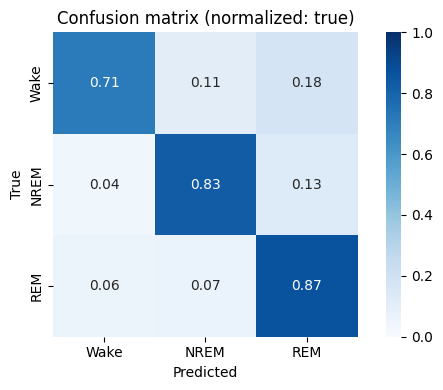

MEDIAN SMOOTHED PREDICTIONS (~20s)

              precision    recall  f1-score   support

        NREM      0.933     0.830     0.878      7453
         REM      0.394     0.870     0.543      1187
        Wake      0.869     0.714     0.784      3436

    accuracy                          0.801     12076
   macro avg      0.732     0.805     0.735     12076
weighted avg      0.861     0.801     0.818     12076



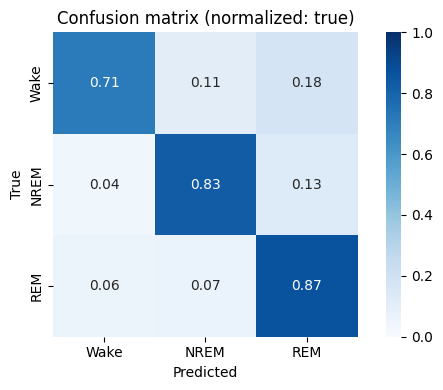

MEDIAN + MIN BOUT SMOOTHED PREDICTIONS (~20s)

              precision    recall  f1-score   support

        NREM      0.921     0.895     0.908      7453
         REM      0.508     0.830     0.630      1187
        Wake      0.857     0.723     0.784      3436

    accuracy                          0.840     12076
   macro avg      0.762     0.816     0.774     12076
weighted avg      0.862     0.840     0.845     12076



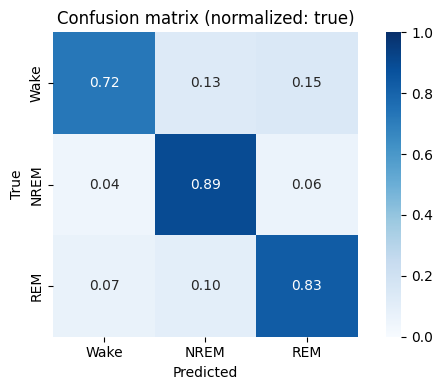

In [490]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced"))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)

print(f'RAW PREDICTIONS\n')
print(classification_report(y_val, y_pred, digits=3))
plot_confusion_matrix(y_val, y_pred, labels=CLASS_ORDER, normalize='true')

y_pred_med20 = smooth_median(y_pred, kernel=median_kernel)  # ~20s
print(f'MEDIAN SMOOTHED PREDICTIONS (~20s)\n')
print(classification_report(y_val, y_pred_med20, digits=3))
plot_confusion_matrix(y_val, y_pred_med20, labels=CLASS_ORDER, normalize="true")

y_pred_smooth  = smooth_min_bout(y_pred_med20, min_len=min_bouts)
print(f'MEDIAN + MIN BOUT SMOOTHED PREDICTIONS (~20s)\n')
print(classification_report(y_val, y_pred_smooth, digits=3))
plot_confusion_matrix(y_val, y_pred_smooth, labels=CLASS_ORDER, normalize="true")

animals: train=12, val=5, test=5


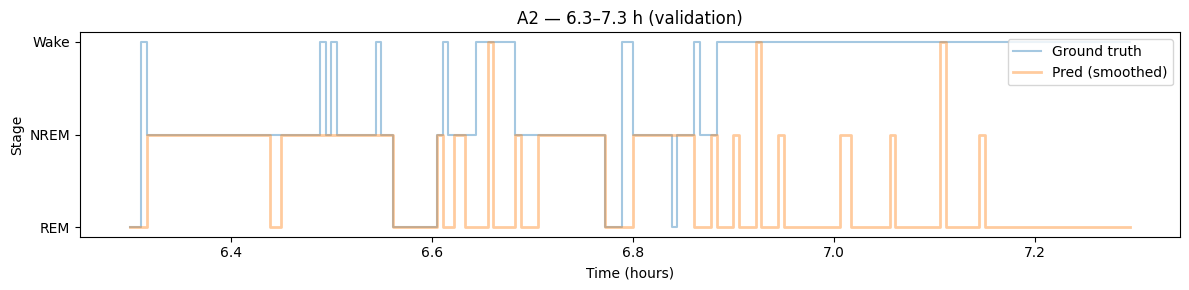

In [491]:
# Get animals per split
train_animals, val_animals, test_animals = animals_by_split(groups, train_idx, val_idx, test_idx)

# pick one from validation (or use test_animals)
animal = sorted(val_animals)[0]              # or: np.random.choice(sorted(val_animals))
assert animal not in train_animals           # double-check

# Now subset the 1-hour window and plot
start_h   = 6.3
duration_h= 1.0

X_win, y_true_win, t_s_win, idx_win = subset_window(
    df, animal, feature_cols, start_h=start_h, duration_h=duration_h
)

# Predict (no leakage: animal is from val/test only)
y_pred_win = pipe.predict(X_win)

# Smooth (optional)
y_pred_med20   = smooth_median(y_pred_win, kernel=median_kernel)  # ~20 s
y_pred_smooth  = smooth_min_bout(y_pred_med20, min_len=min_bouts)

# Plot
plot_hypnogram(
    t_s_win,
    y_true=y_true_win,
    y_pred=None,
    y_pred_smooth=y_pred_smooth,
    title=f"{animal} — {start_h:.1f}–{start_h + duration_h:.1f} h (validation)"
)

### 5.2 XGBoost

XGB (early stopping) — validation
              precision    recall  f1-score   support

        NREM      0.947     0.869     0.906      7453
         REM      0.550     0.811     0.656      1187
        Wake      0.821     0.834     0.828      3436

    accuracy                          0.853     12076
   macro avg      0.773     0.838     0.797     12076
weighted avg      0.872     0.853     0.859     12076



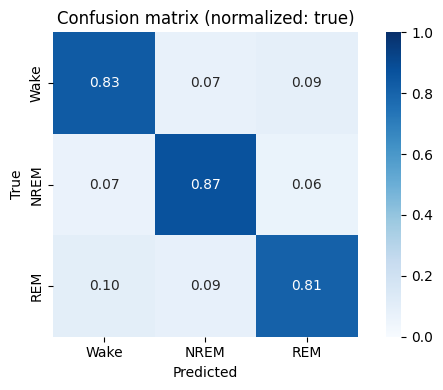

MEDIAN SMOOTHED PREDICTIONS (~20s)

              precision    recall  f1-score   support

        NREM      0.947     0.869     0.906      7453
         REM      0.550     0.811     0.656      1187
        Wake      0.821     0.834     0.828      3436

    accuracy                          0.853     12076
   macro avg      0.773     0.838     0.797     12076
weighted avg      0.872     0.853     0.859     12076



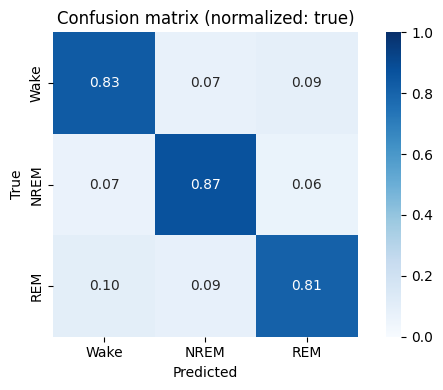

MEDIAN + MIN BOUT SMOOTHED PREDICTIONS (~20s)

              precision    recall  f1-score   support

        NREM      0.934     0.904     0.918      7453
         REM      0.699     0.745     0.721      1187
        Wake      0.812     0.851     0.831      3436

    accuracy                          0.873     12076
   macro avg      0.815     0.833     0.824     12076
weighted avg      0.876     0.873     0.874     12076



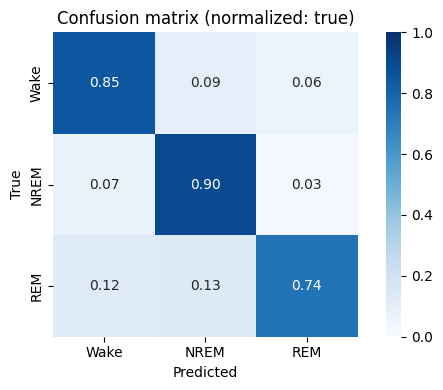

In [492]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# Encode labels
le = LabelEncoder()
y_tr_enc   = le.fit_transform(y_train)
y_val_enc  = le.transform(y_val)
y_test_enc = le.transform(y_test)

# Class-balanced sample weights (boost REM)
classes = np.unique(y_train)
w_map = dict(zip(classes, compute_class_weight("balanced", classes=classes, y=y_train)))
sw_train = np.array([w_map[c] for c in y_train])
sw_val   = np.array([w_map[c] for c in y_val])  # optional if your XGB version supports eval weights

# Build model (note: early_stopping_rounds set on the estimator, not in fit)
clf = XGBClassifier(
    objective="multi:softprob",
    num_class=len(le.classes_),      # harmless; XGB can infer but this is explicit
    n_estimators=3000,               # high cap; early stopping will trim
    learning_rate=0.07,              # << not 0.001
    max_depth=4,
    min_child_weight=1.0,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.0,
    tree_method="hist",              # use "gpu_hist" if you have a GPU
    eval_metric="mlogloss",
    early_stopping_rounds=100,       # <-- moved here
    random_state=42,
)

# Fit
fit_kwargs = dict(eval_set=[(X_val, y_val_enc)], verbose=False)
clf.fit(X_train, y_tr_enc, sample_weight=sw_train, sample_weight_eval_set=[sw_val], **fit_kwargs)

# Evaluate on validation animals
y_pred_enc = clf.predict(X_val)
y_pred = le.inverse_transform(y_pred_enc)

print("XGB (early stopping) — validation")
print(classification_report(y_val, y_pred, digits=3))
plot_confusion_matrix(y_val, y_pred, labels=CLASS_ORDER, normalize="true")

y_pred_med20 = smooth_median(y_pred, kernel=median_kernel)  # ~20s
print(f'MEDIAN SMOOTHED PREDICTIONS (~20s)\n')
print(classification_report(y_val, y_pred_med20, digits=3))
plot_confusion_matrix(y_val, y_pred_med20, labels=CLASS_ORDER, normalize="true")

y_pred_smooth  = smooth_min_bout(y_pred_med20, min_len=min_bouts)
print(f'MEDIAN + MIN BOUT SMOOTHED PREDICTIONS (~20s)\n')
print(classification_report(y_val, y_pred_smooth, digits=3))
plot_confusion_matrix(y_val, y_pred_smooth, labels=CLASS_ORDER, normalize="true")

## 6. Performance on test set

### 6.1 Logistic Regression


TEST SET (held-out animals)

-- Raw predictions --
Accuracy: 0.812
              precision    recall  f1-score   support

        NREM      0.957     0.783     0.861      6332
         REM      0.369     0.885     0.521       978
        Wake      0.900     0.843     0.870      3479

    accuracy                          0.812     10789
   macro avg      0.742     0.837     0.751     10789
weighted avg      0.885     0.812     0.833     10789



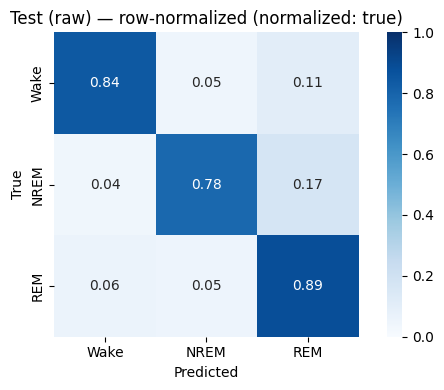


-- Median smoothing (k=5 ≈ 20s) --
Accuracy: 0.812
              precision    recall  f1-score   support

        NREM      0.957     0.783     0.861      6332
         REM      0.369     0.885     0.521       978
        Wake      0.900     0.843     0.870      3479

    accuracy                          0.812     10789
   macro avg      0.742     0.837     0.751     10789
weighted avg      0.885     0.812     0.833     10789



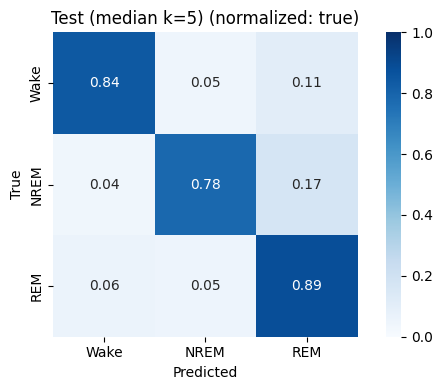


-- Median + minimum-bout smoothing --
Accuracy: 0.848
              precision    recall  f1-score   support

        NREM      0.942     0.849     0.893      6332
         REM      0.465     0.839     0.599       978
        Wake      0.890     0.850     0.870      3479

    accuracy                          0.848     10789
   macro avg      0.766     0.846     0.787     10789
weighted avg      0.882     0.848     0.859     10789



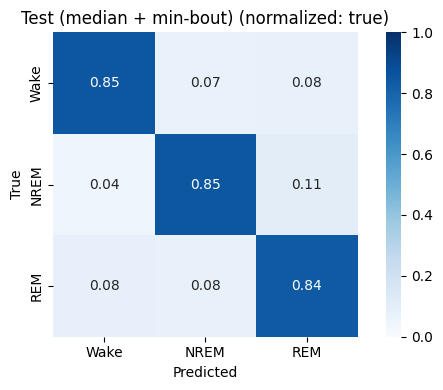

In [493]:
# ---------- TEST EVALUATION ----------
print("\n==============================")
print("TEST SET (held-out animals)")
print("==============================")

# Raw predictions
y_pred_test = pipe.predict(X_test)

print("\n-- Raw predictions --")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
print(classification_report(y_test, y_pred_test, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_pred_test, labels=CLASS_ORDER,
                          normalize="true", title="Test (raw) — row-normalized")

# Median smoothing (~20 s if 4 s epochs & kernel=5)
y_pred_test_med = smooth_median(y_pred_test, kernel=median_kernel)
print("\n-- Median smoothing (k=5 ≈ 20s) --")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test_med):.3f}")
print(classification_report(y_test, y_pred_test_med, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_pred_test_med, labels=CLASS_ORDER,
                          normalize="true", title="Test (median k=5)")

# Median + minimum-bout smoothing
y_pred_test_smooth = smooth_min_bout(y_pred_test_med, min_len=min_bouts)
print("\n-- Median + minimum-bout smoothing --")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test_smooth):.3f}")
print(classification_report(y_test, y_pred_test_smooth, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_pred_test_smooth, labels=CLASS_ORDER,
                          normalize="true", title="Test (median + min-bout)")

animals: train=12, val=5, test=5


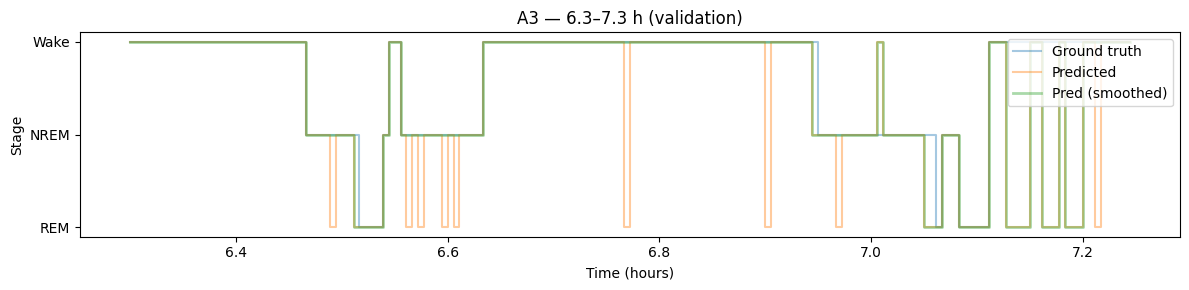

In [494]:
# Get animals per split
train_animals, val_animals, test_animals = animals_by_split(groups, train_idx, val_idx, test_idx)

# pick one from validation (or use test_animals)
animal = sorted(test_animals)[0]              # or: np.random.choice(sorted(val_animals))
assert animal not in train_animals           # double-check

# Now subset the 1-hour window and plot
start_h   = 6.3
duration_h= 1.0

X_win, y_true_win, t_s_win, idx_win = subset_window(
    df, animal, feature_cols, start_h=start_h, duration_h=duration_h
)

# Predict (no leakage: animal is from val/test only)
y_pred_win = pipe.predict(X_win)

# Smooth (optional)
y_pred_med20   = smooth_median(y_pred_win, kernel=median_kernel)  # ~20 s
y_pred_smooth  = smooth_min_bout(y_pred_med20, min_len=min_bouts)

# Plot
plot_hypnogram(
    t_s_win,
    y_true=y_true_win,
    y_pred=y_pred_win,
    y_pred_smooth=y_pred_smooth,
    title=f"{animal} — {start_h:.1f}–{start_h + duration_h:.1f} h (validation)"
)

### 6.2 XGBoost


TEST SET (held-out animals)

-- Raw predictions --
Accuracy: 0.828
              precision    recall  f1-score   support

        NREM      0.980     0.780     0.869      6332
         REM      0.458     0.715     0.559       978
        Wake      0.780     0.947     0.855      3479

    accuracy                          0.828     10789
   macro avg      0.739     0.814     0.761     10789
weighted avg      0.868     0.828     0.836     10789



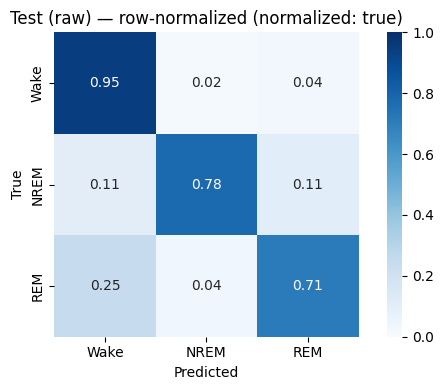


-- Median smoothing (k=5 ≈ 20s) --
Accuracy: 0.828
              precision    recall  f1-score   support

        NREM      0.980     0.780     0.869      6332
         REM      0.458     0.715     0.559       978
        Wake      0.780     0.947     0.855      3479

    accuracy                          0.828     10789
   macro avg      0.739     0.814     0.761     10789
weighted avg      0.868     0.828     0.836     10789



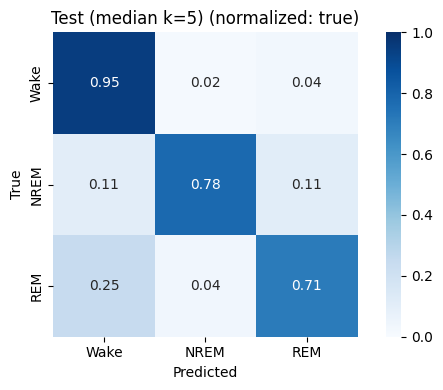


-- Median + minimum-bout smoothing --
Accuracy: 0.855
              precision    recall  f1-score   support

        NREM      0.969     0.831     0.895      6332
         REM      0.619     0.653     0.636       978
        Wake      0.768     0.954     0.851      3479

    accuracy                          0.855     10789
   macro avg      0.785     0.813     0.794     10789
weighted avg      0.872     0.855     0.857     10789



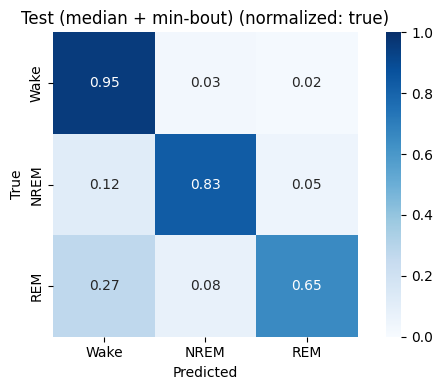

In [495]:
# ---------- TEST EVALUATION ----------
print("\n==============================")
print("TEST SET (held-out animals)")
print("==============================")

# Raw predictions
y_pred_test_enc = clf.predict(X_test)
y_pred_test = le.inverse_transform(y_pred_test_enc)

print("\n-- Raw predictions --")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
print(classification_report(y_test, y_pred_test, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_pred_test, labels=CLASS_ORDER,
                          normalize="true", title="Test (raw) — row-normalized")

# Median smoothing (~20 s if 4 s epochs & kernel=5)
y_pred_test_med = smooth_median(y_pred_test, kernel=median_kernel)
print("\n-- Median smoothing (k=5 ≈ 20s) --")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test_med):.3f}")
print(classification_report(y_test, y_pred_test_med, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_pred_test_med, labels=CLASS_ORDER,
                          normalize="true", title="Test (median k=5)")

# Median + minimum-bout smoothing

y_pred_test_smooth = smooth_min_bout(y_pred_test_med, min_len=min_bouts)
print("\n-- Median + minimum-bout smoothing --")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test_smooth):.3f}")
print(classification_report(y_test, y_pred_test_smooth, digits=3, zero_division=0))
plot_confusion_matrix(y_test, y_pred_test_smooth, labels=CLASS_ORDER,
                          normalize="true", title="Test (median + min-bout)")


animals: train=12, val=5, test=5


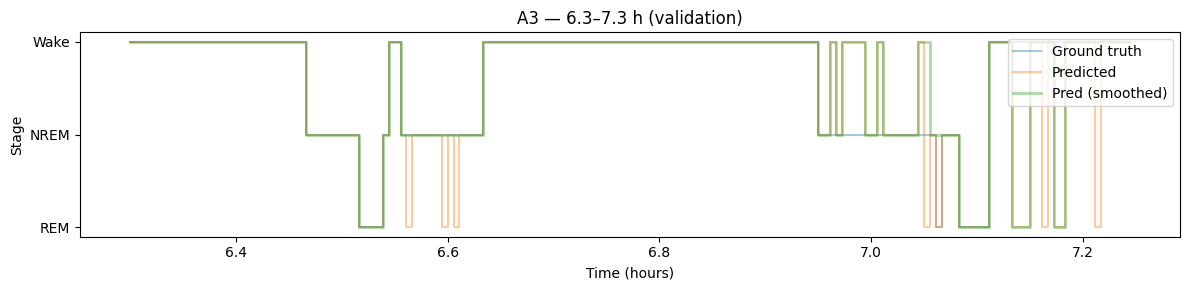

In [496]:
# Get animals per split
train_animals, val_animals, test_animals = animals_by_split(groups, train_idx, val_idx, test_idx)

# pick one from validation (or use test_animals)
animal = sorted(test_animals)[0]              # or: np.random.choice(sorted(val_animals))
assert animal not in train_animals           # double-check

# Now subset the 1-hour window and plot
start_h   = 6.3
duration_h= 1.0

X_win, y_true_win, t_s_win, idx_win = subset_window(
    df, animal, feature_cols, start_h=start_h, duration_h=duration_h
)

# Predict (no leakage: animal is from val/test only)
y_pred_win = clf.predict(X_win)
y_pred_win = le.inverse_transform(y_pred_win)

# Smooth (optional)
y_pred_med20   = smooth_median(y_pred_win, kernel=median_kernel)  # ~20 s
y_pred_smooth  = smooth_min_bout(y_pred_med20, min_len=min_bouts)

# Plot
plot_hypnogram(
    t_s_win,
    y_true=y_true_win,
    y_pred=y_pred_win,
    y_pred_smooth=y_pred_smooth,
    title=f"{animal} — {start_h:.1f}–{start_h + duration_h:.1f} h (validation)"
)

In [497]:
def animals_by_split(groups, train_idx, val_idx, test_idx):
    g = np.asarray(groups)
    tr, va, te = set(g[train_idx]), set(g[val_idx]), set(g[test_idx])
    assert tr.isdisjoint(va) and tr.isdisjoint(te) and va.isdisjoint(te)
    print(f"animals: train={len(tr)}, val={len(va)}, test={len(te)}")
    return tr, va, te

train_animals, val_animals, test_animals = animals_by_split(groups, train_idx, val_idx, test_idx)

animals: train=12, val=5, test=5


In [498]:
from collections import Counter

def class_balance(y, idx, name):
    c = Counter(y[idx])
    tot = len(idx)
    print(f"[{name}] n={tot}  " + ", ".join(f"{k}={c.get(k,0)} ({c.get(k,0)/tot:.1%})" for k in ["Wake","NREM","REM"]))

class_balance(y, train_idx, "train")
class_balance(y, val_idx,   "val")
class_balance(y, test_idx,  "test")


[train] n=32762  Wake=11568 (35.3%), NREM=18175 (55.5%), REM=3019 (9.2%)
[val] n=12076  Wake=3436 (28.5%), NREM=7453 (61.7%), REM=1187 (9.8%)
[test] n=10789  Wake=3479 (32.2%), NREM=6332 (58.7%), REM=978 (9.1%)


In [499]:
def cohorts_in_split(df, idx, name):
    print(f"\n[{name}] cohorts:")
    print(df.iloc[idx].groupby("cohort").size().sort_values(ascending=False))

cohorts_in_split(df, train_idx, "train")
cohorts_in_split(df, val_idx,   "val")
cohorts_in_split(df, test_idx,  "test")


[train] cohorts:
cohort
CohortD    17260
CohortC     8392
CohortA     3769
CohortB     3341
dtype: int64

[val] cohorts:
cohort
CohortC    4502
CohortD    4319
CohortA    2106
CohortB    1149
dtype: int64

[test] cohorts:
cohort
CohortD    4319
CohortC    4282
CohortA    1305
CohortB     883
dtype: int64
